In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
# show image

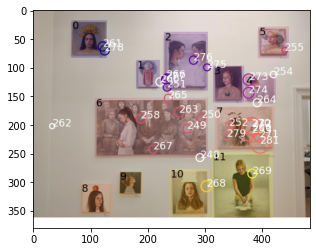

In [3]:
path = './RIM_data/'
image = mpimg.imread(path + 'aois_fixations_on_reference_image_nested.png')
plt.imshow(image);

In [4]:
# plot fixation durations per aoi
fixations = pd.read_csv(path + 'fixations_with_aois_nested.csv')
# drop na fixations (only fixations on AOI)
fixations = fixations.dropna(axis = 0)
fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,249,1.636036e+18,1.636036e+18,223,True,2224,1717,6.0
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,250,1.636036e+18,1.636036e+18,240,True,2427,1559,6.0
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,251,1.636036e+18,1.636036e+18,196,True,1935,1119,2.0
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,252,1.636036e+18,1.636036e+18,159,True,2828,1668,7.0
6,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,261,1.636036e+18,1.636036e+18,268,True,1011,529,0.0


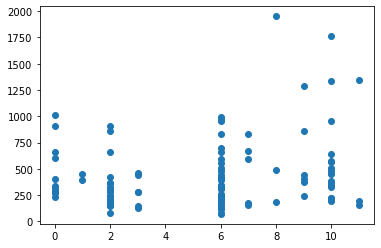

In [5]:
# Totally basic data - scatter plot of duration of fixations on each AOI
plt.scatter(fixations['AOI'], fixations['duration [ms]']);

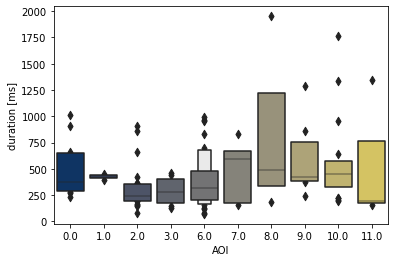

In [6]:
# seaborn boxenplots
sns.boxenplot(
    x = 'AOI',
    y = 'duration [ms]',
    data=fixations,
    palette = 'cividis'
);

This is ok, but not really easy to read and this visualization looks weird for data sets with few data points. It's alos hidden here if there are very few data points in these plots.

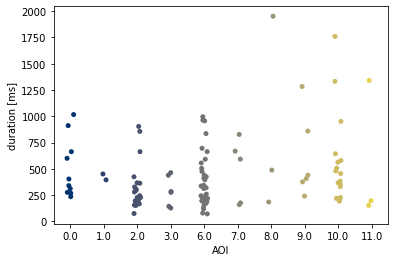

In [7]:
# seaborn stipplot
sns.stripplot(
    x = 'AOI',
    y = 'duration [ms]',
    data=fixations,
    palette = 'cividis'
);

This a better view to visualize each data point, but it's not intuitive how to extract summary statistics here.

In [39]:
def get_quantile_series(data, quantiles):
    values = data.quantile(quantiles)
    quantile_list = pd.Series(np.zeros(len(data)), index = data.index)
    quantile_values = pd.Series(np.zeros(len(data)), index = data.index)
        
    last_val = 0
    for q, val in zip(quantiles, values):
        quantile_list.loc[(data <= val) & (data >= last_val)] = q
        quantile_values.loc[(data <= val) & (data >= last_val)] = val
    
        last_val = val
        
    return quantile_list, quantile_values

def get_fractions_series(data, fractions):
    last_val = 0
    fractions_list = pd.Series(np.zeros(len(data)), index = data.index)
    
    for val in fractions:
        fractions_list.loc[(data <= val) & (data >= last_val)] = val
        last_val = val
        
    return fractions_list

quantiles = np.linspace(0,1,11) 
fractions = np.linspace(0, max(fixations['duration [ms]']), 10)

q_list, q_values = get_quantile_series(fixations['duration [ms]'], quantiles)
fixations['duration_quantiles'] = q_list
fixations['values_quantiles'] = q_values
fixations['duration_fractions'] = get_fractions_series(fixations['duration [ms]'], fractions)

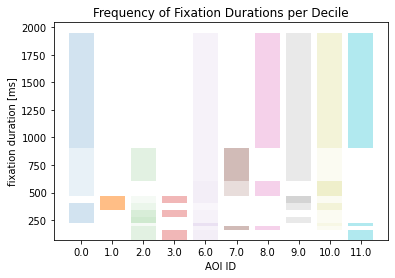

In [74]:
# Show quantiles
# stacked barplots
x_vals = np.unique(fixations['AOI'])
bottom = np.array([fixations['duration [ms]'].quantile(0)] * len(x))

for q in quantiles:
    plot_data = fixations[fixations['duration_quantiles'] == q]
    
    x = x_vals
    y = np.array([fixations['duration [ms]'].quantile(q)] * len(x))
    
    group_counts = plot_data.groupby(['AOI']).count()['duration [ms]'].reset_index()
    alpha = np.zeros(len(x))
    alpha[np.isin(x, group_counts['AOI'])] = group_counts['duration [ms]']
    alpha = alpha/fixations.groupby(['AOI']).count()['duration [ms]'].values
    
    
    for ind_x, ind_y, ind_a, ind_bottom in zip(x, y, alpha, bottom):    
        plt.bar(
            str(ind_x),
            ind_y - ind_bottom,
            bottom = ind_bottom,
            alpha = ind_a
        );
    
    bottom = y
    
plt.xlabel('AOI ID')
plt.ylabel('fixation duration [ms]')
plt.title('Frequency of Fixation Durations per Decile');

Quantiles are hard to read - the highest quantile spans from ~900 to ~2000 ms, creating big blocks on top of the distribution. These blocks create the impression for a top-biased distribution of the data which is not the case if we look at the individual data points. Hence, it is not recommended to use quantiles in these distributions.

Instead for quantiles, we can also use sections of the fixation duration time:

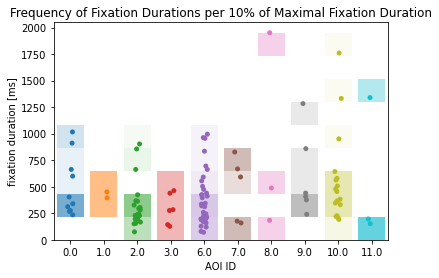

In [68]:
# stacked barplots
x_vals = np.unique(fixations['AOI'])
y_vals = np.zeros(len(x_vals))
bottom = np.array([0] * len(x_vals))


for q in fractions:
    plot_data = fixations[fixations['duration_fractions'] == q]
    
    x = x_vals
    y = np.array([q] * len(x))
    
    group_counts = plot_data.groupby(['AOI']).count()['duration [ms]'].reset_index()
    
    alpha = np.zeros(len(x))
    alpha[np.isin(x, group_counts['AOI'])] = group_counts['duration [ms]']
    alpha = alpha/fixations.groupby(['AOI']).count()['duration [ms]'].values
    
    
    for ind_x, ind_y, ind_a, ind_bottom in zip(x, y, alpha, bottom):    
        plt.bar(
            str(ind_x),
            ind_y - ind_bottom,
            bottom = ind_bottom,
            alpha = ind_a
        );
    
    bottom = y

# seaborn stipplot
sns.stripplot(
    x = 'AOI',
    y = 'duration [ms]',
    data=fixations,
);    

plt.xlabel('AOI ID')
plt.ylabel('fixation duration [ms]')
plt.title('Frequency of Fixation Durations per 10% of Maximal Fixation Duration');

This already gives us a more accurate picture of what is going on in the data - but the colors don't show which AOI attracted the most fixations. So to visualize that, we will normalize fixations counts to the total number of fixations.

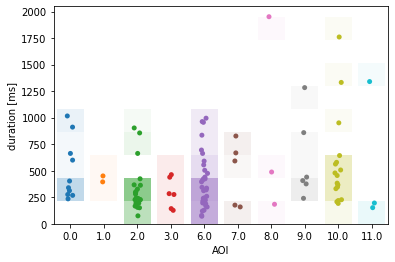

In [56]:
# stacked barplots
x_vals = np.unique(fixations['AOI'])
y_vals = np.zeros(len(x_vals))
bottom = np.array([0] * len(x_vals))


for q in fractions:
    plot_data = fixations[fixations['duration_fractions'] == q]
    
    x = x_vals
    y = np.array([q] * len(x))
    
    group_counts = plot_data.groupby(['AOI']).count()['duration [ms]'].reset_index()
    
    alpha = np.zeros(len(x))
    alpha[np.isin(x, group_counts['AOI'])] = group_counts['duration [ms]']
    
    # hacky setting of the alpha-level
    alpha = alpha/len(fixations) * 5
    
    
    for ind_x, ind_y, ind_a, ind_bottom in zip(x, y, alpha, bottom):    
        plt.bar(
            str(ind_x),
            ind_y - ind_bottom,
            bottom = ind_bottom,
            alpha = ind_a
        );
    
    bottom = y

# seaborn stipplot
sns.stripplot(
    x = 'AOI',
    y = 'duration [ms]',
    data=fixations,
);

That was a somewhat hacky way to set the alpha-level, because I am running short on time. 

This plot, however looks intuitive. We can at which AOI the most fixations occurred and where the outliers are.

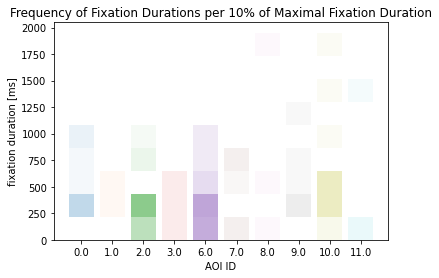

In [70]:
# stacked barplots
x_vals = np.unique(fixations['AOI'])
y_vals = np.zeros(len(x_vals))
bottom = np.array([0] * len(x_vals))


for q in fractions:
    plot_data = fixations[fixations['duration_fractions'] == q]
    
    x = x_vals
    y = np.array([q] * len(x))
    
    group_counts = plot_data.groupby(['AOI']).count()['duration [ms]'].reset_index()
    
    alpha = np.zeros(len(x))
    alpha[np.isin(x, group_counts['AOI'])] = group_counts['duration [ms]']
    
    # hacky setting of the alpha-level
    alpha = alpha/len(fixations) * 5
    
    
    for ind_x, ind_y, ind_a, ind_bottom in zip(x, y, alpha, bottom):    
        plt.bar(
            str(ind_x),
            ind_y - ind_bottom,
            bottom = ind_bottom,
            alpha = ind_a
        );
    
    bottom = y
    
plt.xlabel('AOI ID')
plt.ylabel('fixation duration [ms]')
plt.title('Frequency of Fixation Durations per 10% of Maximal Fixation Duration')

plt.savefig('FreqFixDur_Max.png');